### Get Data and Visualize

In [1]:
from charge_optimizer import ChargeOptimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from price_optimizer import PriceOptimizer

In [2]:
df = pd.read_csv('Data_Households_SmartPV.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

weekday_df = df[df['Timestamp'].dt.dayofweek < 5]
weekday_avg = weekday_df.groupby([weekday_df['Timestamp'].dt.hour, weekday_df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-15 00:00:00', end='2016-06-15 23:30:00', freq='30min')
weekday_avg['Timestamp'] = timestamps
weekday_avg.set_index('Timestamp', inplace=True)
weekday_avg = weekday_avg / 1000  # Convert to kWh
weekday_avg.head()




,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-06-15 00:00:00,0.614941,0.845336,0.0,0.586632,0.0,0.845336,0.845336
2016-06-15 00:30:00,0.614931,0.789306,0.0,0.586633,0.0,0.789306,0.789306
2016-06-15 01:00:00,0.614941,0.747229,0.0,0.586632,0.0,0.747229,0.747229
2016-06-15 01:30:00,0.614931,0.720732,0.0,0.586633,0.0,0.720732,0.720732
2016-06-15 02:00:00,0.614941,0.688052,0.0,0.586632,0.0,0.688052,0.688052


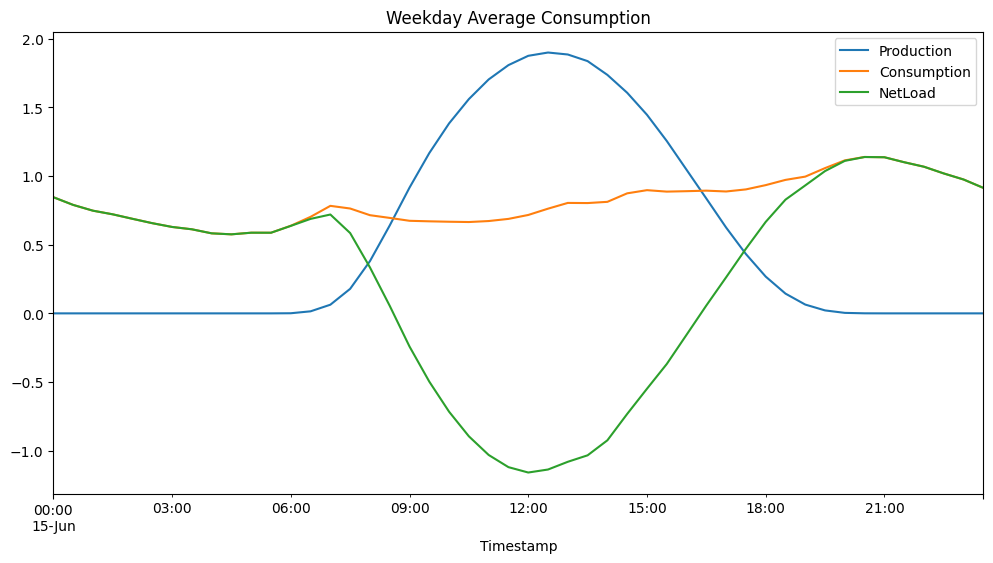

In [3]:
_ = weekday_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Weekday Average Consumption', figsize=(12, 6))

### Battery Control

This optimization is the basic scenario of controlling the battery for a day. Primarily, this is meant to test functionality of the optimization before scaling to more complicated pricing schemes. 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.339566906839909
            Iterations: 77
            Function evaluations: 4020
            Gradient evaluations: 77


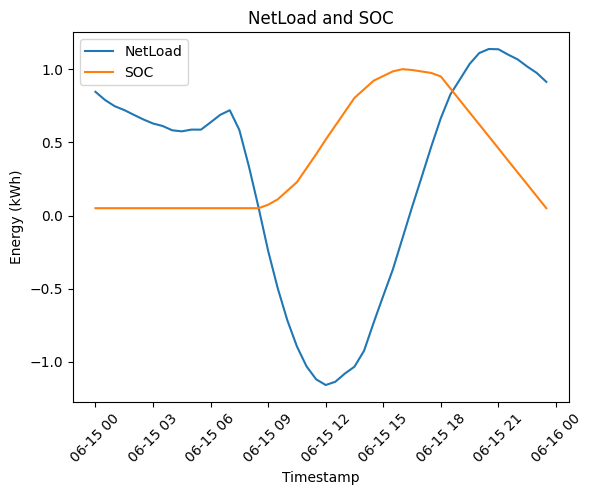

In [3]:
BATT_PRICE_PER_KWH = 127  # Euros per kWh (127 is what was found online)
max_charge_rate = 0.5  # Max charge rate in % per hour
max_discharge_rate = 0.5  # Max discharge rate in % per hour
soc_min = 0.05  # Maximum Depth of Discharge 95%
soc_max = 1.00  # Maximum State of Charge 100%; can play around with to protect battery
sqrt_eff = 0.98  # round trip Efficiency of the battery
self_discharge = 0.0  # 5% self discharge per day; totally made up
batt_life = 10 # years; totally made up
import_tariff = np.full(24, 0.37) # Single price tariff; 0.37 Euros per kWh
export_tariff = np.zeros(24)


charge_optimizer = ChargeOptimizer(
    pred_net_load=weekday_avg['NetLoad'],
    duration=1,
    import_tariff=import_tariff,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5, # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
    batt_capacity=10,  # 13.5 kWh
    export_tariff=export_tariff,
)

charge_optimizer.local_optimize(method='SLSQP', tol=1e-6)
charge_optimizer.plot_results(weekday_avg.index)

### Convex Optimization using CXVPY

This approach uses a specialty package, cxvpy, for convex optimization of the problem. But, I haven't been able to get it to work given convexity issues.

In [5]:
prob, charge, discharge = charge_optimizer.convex_optimize(10)
type(prob)
type(charge)
type(discharge)

status: infeasible
optimal value inf
optimal var None None


cvxpy.expressions.variable.Variable

# Optimization of Battery Size for Net Savings

This optimization accounts for the price of batteries and finds the optimal battery size to save consumers money (for the specified sample of 3kW systems). This exists for both TOU tariffs and single-price tariffs. 

Information: https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
https://natec.com/wp-content/uploads/2020/12/6020-0205-Datasheet-LG-Chem-RESU-10H-High-Voltage-400V-type-C-for-SMA.pdf

## Single Price Tariff Optimization

Although Cyprus uses Net-Metering, this study examines export energy that does not recieve remuneration

### Local Minimization

This code examines local minimization of the basic problem using SciPy minimize with SLSQP method.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.069383002024191
            Iterations: 451
            Function evaluations: 24024
            Gradient evaluations: 451
Battery Size: 12.053552157186488 kWh
Objective Function Final Value: 5.069383002024191


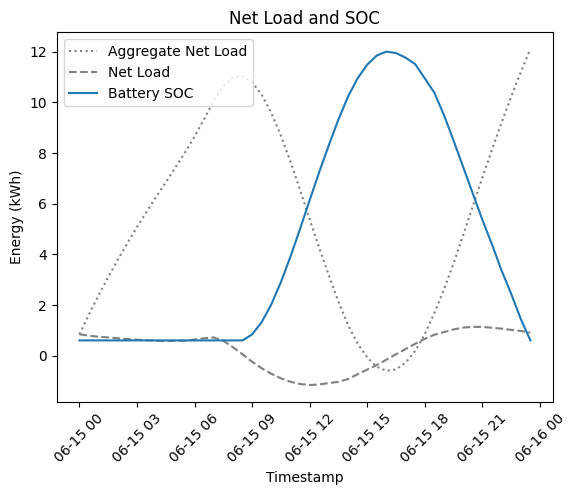

In [4]:

price_optimizer = PriceOptimizer(
    pred_net_load=weekday_avg["NetLoad"],
    duration=1,
    batt_price_per_kWh=BATT_PRICE_PER_KWH,
    import_tariff=import_tariff,
    export_tariff=export_tariff,
    batt_life=batt_life,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5,  # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
)

price_optimizer.local_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)


### Global Minimization

This code examines the same, simple problem above. However, here we use global minimization with differential evolution. The results are somewhat surprising upon first examination; global minimization should outperform local minimization if correctly done. However, given that the initial guess provided to local minimization makes strong inuitive sense given the problem at hand, we can imagine that the local minimization is better equipped to more quickly hone in on the optimal spread. However, future work could be done to refine the globalization model (such as different strategies and searching time) that could/should result in results as good as the local minimization.  

Battery Size: 9.894545176236953 kWh
Objective Function Final Value: 5.837837827110047


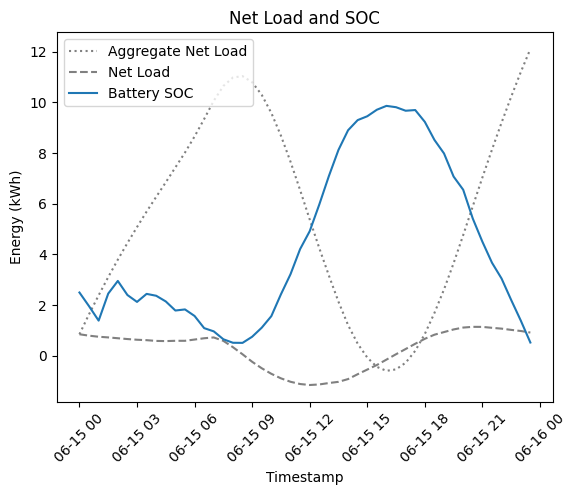

In [22]:
price_optimizer.batt_ub = 10 # Close bounds for global optimization
price_optimizer.batt_lb = 2
price_optimizer.global_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

### Bi-Level Optimization

This optimization method uses a two-tiered approach. The first, or "inner", optimization works to minimize an objective function pertaining to only the charge control. The outer optimization takes the inner optimization as an objective function and works to optimize the capacity of the battery for cost-savings. This approach should have to advantages: The first is to simply a complex optimization problem into two very simple problems. Both charge control and battery size are simple problems by themselves – as such, this optimization should take advantage of the easy nature of the decomposed problem. The second is to place an emphasis on battery capacity. In the above optimizations, the battery size is just another input variable like any of the timepoints. In larger and larger duration optimizations this will become problematic because battery size is an extremely important input. Yet to have it be one of tens of thousands of inputs will overcomplicate the model; thus, this approach more naturally addresses the structure of the problem. 

In the first cell we visualize this phenomenon by plotting the output of the charge minimization with respect to x. This allows us to visualize how the minimization works. 

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


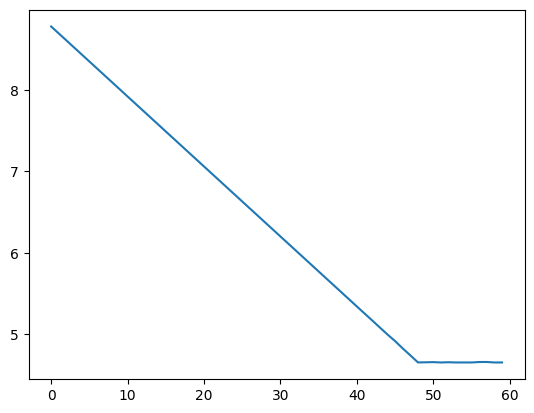

In [8]:

price_optimizer.batt_ub = 100 # Open bounds for other optimization
price_optimizer.batt_lb = 0

objective_vals = []

for i in range(0, 60):
    charge_optimizer.set_batt_capacity(i / 4.0)
    charge_optimizer.local_optimize(method='SLSQP', disp=False, tol=1e-6)
    objective_vals.append(float(charge_optimizer.result.fun))
    print(f'Iteration: {i}')

plt.plot(range(0, 60), objective_vals)


Iteration of battery capacity: 2.0. Objective value: 8.164916458446314
Iteration of battery capacity: 4.0. Objective value: 7.545565415970276
Iteration of battery capacity: 2.309675521238019. Objective value: 8.069017544423309
Iteration of battery capacity: 4.3096755212380184. Objective value: 7.449666586062541
Iteration of battery capacity: 3.5483776061900945. Objective value: 7.685421828485477
Iteration of battery capacity: 5.548377606190094. Objective value: 7.066070931910717
Iteration of battery capacity: 8.503185945998396. Objective value: 6.151038490632857
Iteration of battery capacity: 10.503185945998396. Objective value: 5.53168831346694
Iteration of battery capacity: 28.322419305231605. Objective value: 5.635593453517353
Iteration of battery capacity: 30.322419305231605. Objective value: 5.705844491963499
Iteration of battery capacity: 25.64090580380109. Objective value: 5.542754040511623
Iteration of battery capacity: 27.64090580380109. Objective value: 5.6124098464866625
Ite

/Users/alextseng/MacDocuments/foss-optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Battery Size: 11.956258859047912 kWh
Objective Function Final Value: 4.671600824195225


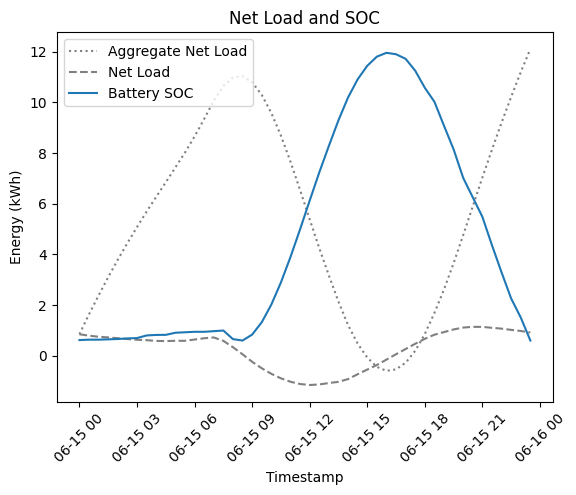

In [6]:
price_optimizer.bilevel_optimize(method='BFGS')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

## Average Week Optimization

Up to this point, we have explored an average day. Although this allows us to visually and intuitively check the correctness of optimization, it is also fairly trivial and provides little meaningful information. Here we scale the optimization to an average week, month, and year. 

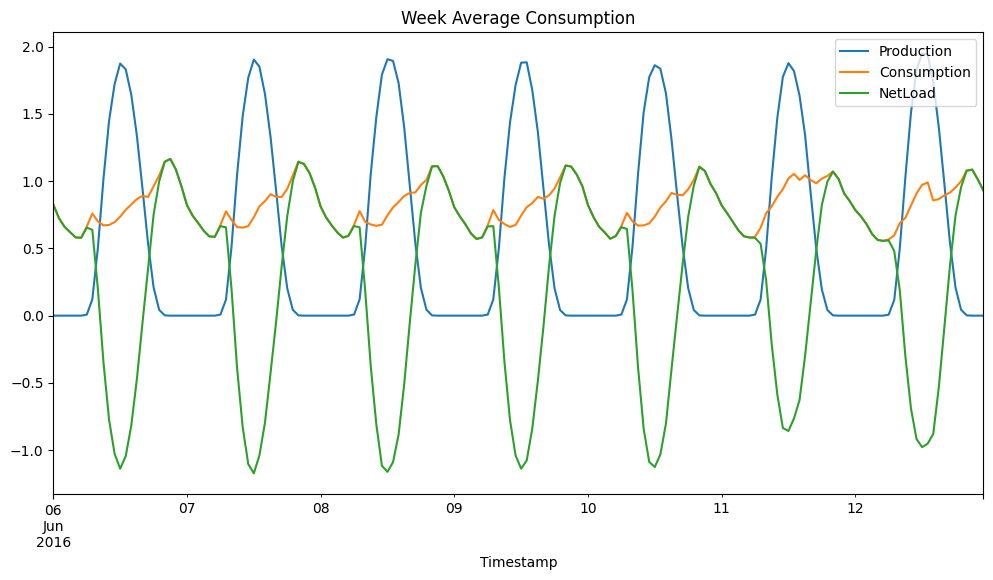

In [5]:
week_avg = df.groupby([df['Timestamp'].dt.day_of_week, df['Timestamp'].dt.hour]).mean()
timestamps = pd.date_range(start='2016-06-06 00:00:00', end='2016-06-12 23:30:00', freq='1h')
week_avg['Timestamp'] = timestamps
week_avg.set_index('Timestamp', inplace=True)
week_avg.index = pd.to_datetime(week_avg.index)
week_avg = week_avg / 1000  # Convert to kWh
week_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Week Average Consumption', figsize=(12, 6))

# Adjust the optimizers accordingly
charge_optimizer.set_new_input(week_avg['NetLoad'], 7, import_tariff, export_tariff, 1)
price_optimizer.set_new_input(week_avg['NetLoad'], 7, import_tariff, export_tariff, 1)

plt.show()

### Charge Optimization
```
Models       |  Function Value  |  Time     |  Resolution
SLSQP        |  49.26408798     |  4m 43.8s |  30min
SLSQP        |  22.24           |  33.8s    |  1h
trust-constr |  High (Error)    |  8m 53.2s |  30min
TNC          |  Broke Const.    |  2.3s     |  30min
L-BFGS-B     |  No Const. Sup.  |  1.7s     |  30min
L-BFGS-B*    |  24.65236        |  4.2s     |  1h
```
Result: SLSQP can serve as the accurate baseline with which to compare other models. More advanced algorithmic structures must be implemented to incorporate these larger time-series models with battery capacity optimization. Work to achieve this improvement is below. 

*Includes constraints in objective func through an exponential penalty component for SOC points

Optimizing for 7 days
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.77501594905954
            Iterations: 166
            Function evaluations: 28493
            Gradient evaluations: 166


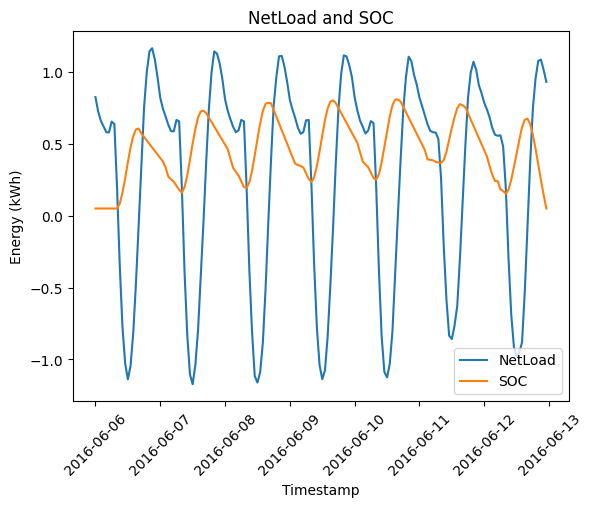

In [31]:
charge_optimizer.set_batt_capacity(10)
print(f'Optimizing for {charge_optimizer.duration} days')
charge_optimizer.local_optimize(method='SLSQP', tol=1e-4)
charge_optimizer.plot_results(week_avg.index)

## L-BFGS-B Optimization with Penalty Based Constraints

Although L-BFGS-B does not natively handle constraints, this section attempts to manually create (relatively) smooth penalties for the objective function by implementing exponential factors for either level of SOC. The main risk with placing this penalty is the distortion of the gradient outside of the constraint bound territory. However, if this could function then L-BGFS-B could be utilized for its high input efficiency – greatly improving optimization speed. 

Below you can visualize the penalty method to create an artifical constraint in the L-BFGS-B method. The sharper the exponential increase the more accurately the optimization describes realty, but the more poorly the optimization runs 

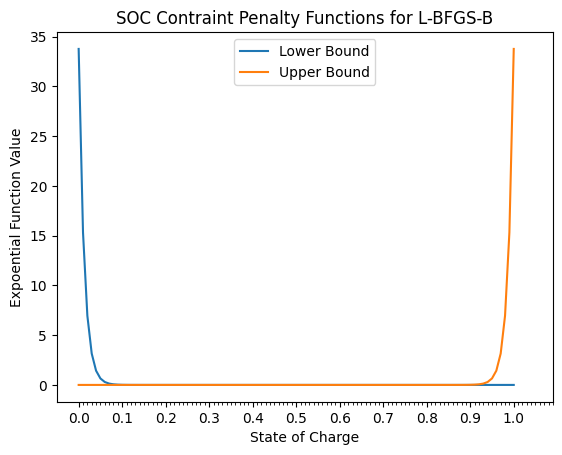

In [9]:
exp_func_params = (0.65, 79)
soc = np.arange(0, 1.01, 0.01)

soc_lb = exp_func_params[0] * np.exp(-exp_func_params[1] * (soc - 0.05))
soc_ub = exp_func_params[0] * np.exp(exp_func_params[1] * (soc - 0.95))

plt.plot(soc, soc_lb, label='Lower Bound')
plt.plot(soc, soc_ub, label='Upper Bound')
plt.xlabel('State of Charge')
plt.ylabel('Expoential Function Value')
plt.title('SOC Contraint Penalty Functions for L-BFGS-B')
plt.xticks(np.arange(0, 1.1, 0.1), minor=False)
plt.xticks(np.arange(0, 1.1, 0.01), minor=True)
plt.legend()
plt.show()

*Cutoff and Maxfun*

Below we find somewhat optimal inputs for the exp_func_params. The maxfun is currently the operation controlling the runtime of the operation. The lower maxfun is the quicker the program runs (linearly), but the worse it runs (appears to be exponential decay, but I need to look into this more)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          168     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34313D+01    |proj g|=  5.00000D-01

At iterate    1    f=  3.30953D+01    |proj g|=  9.00405D-01

At iterate    2    f=  3.26412D+01    |proj g|=  8.99719D-01

At iterate    3    f=  3.16461D+01    |proj g|=  8.96654D-01

At iterate    4    f=  3.06346D+01    |proj g|=  5.26684D-01

At iterate    5    f=  2.84378D+01    |proj g|=  8.79461D-01

At iterate    6    f=  2.66224D+01    |proj g|=  5.68784D-01

At iterate    7    f=  2.62737D+01    |proj g|=  5.66976D-01

At iterate    8    f=  2.59608D+01    |proj g|=  5.72021D-01

At iterate    9    f=  2.51197D+01    |proj g|=  5.85539D-01

At iterate   10    f=  2.47427D+01    |proj g|=  5.89897D-01

At iterate   11    f=  2.45162D+01    |proj g|=  5.87712D-01

At iterate   12    f=  2.42614D+01    |proj g|=  8.67858D-01

At iterate   13    f=  2.3

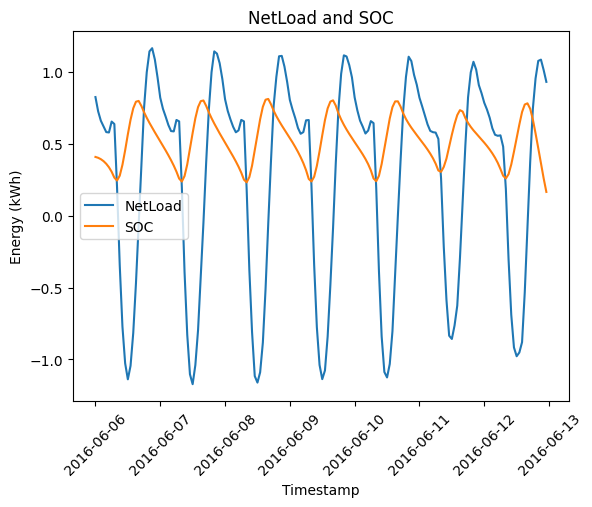

17.32559695241279

In [21]:
charge_optimizer.l_bfgs_b_optimize(exp_func_params=(1, 15), maxiter=3000, maxfun=10000)
charge_optimizer.plot_results(week_avg.index)
charge_optimizer.final_objective()

*Visualize outer optimization*

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

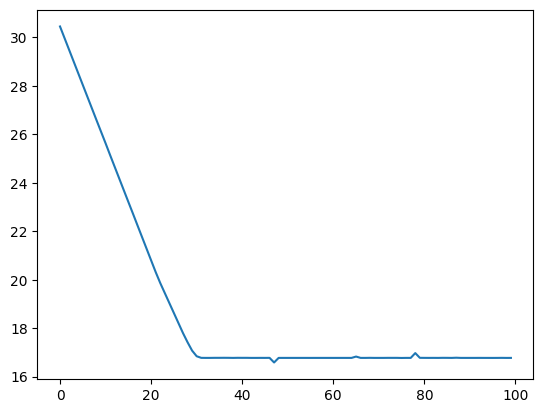

In [33]:
objective_vals = []

for i in range(0, 100):
    charge_optimizer.set_batt_capacity(i / 5.0)
    charge_optimizer.local_optimize(disp=False, tol=1e-6)
    objective_vals.append(float(charge_optimizer.result.fun))
    print(f'Iteration: {i}')

plt.plot(range(0, 100), objective_vals)

## Week Range Bi-Level Optimization
### L-BFGS-B as inner Optimization
Given the improved speed performance of the L-BFGS-B optimization for the charge optimization, we here attempt to use this as an efficient inner method to the bi-level optimization implemented above. 

/Users/alextseng/MacDocuments/foss-optimization/price_optimizer.py:118: RuntimeWarning: Method BFGS cannot handle bounds.
  result = spo.minimize(


Iteration of battery capacity: 2.0. Objective value: 27.80172101828686
Iteration of battery capacity: 4.0. Objective value: 25.28432970829865
Iteration of battery capacity: 3.0100000000000016. Objective value: 26.53010960628692
Iteration of battery capacity: 5.010000000000002. Objective value: 24.333874618312944
Iteration of battery capacity: 5.349144095513619. Objective value: 24.098636326393343
Iteration of battery capacity: 7.349144095513619. Objective value: 25.11783057232676
Iteration of battery capacity: 4.607705852240725. Objective value: 24.702959418117533
Iteration of battery capacity: 6.607705852240725. Objective value: 24.738911664678085
Iteration of battery capacity: 5.290597866597096. Objective value: 24.15233557201347
Iteration of battery capacity: 7.290597866597096. Objective value: 25.095826325570158
Iteration of battery capacity: 5.345388057938549. Objective value: 24.131051562824837
Iteration of battery capacity: 7.345388057938549. Objective value: 25.114871384826532


/Users/alextseng/MacDocuments/foss-optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


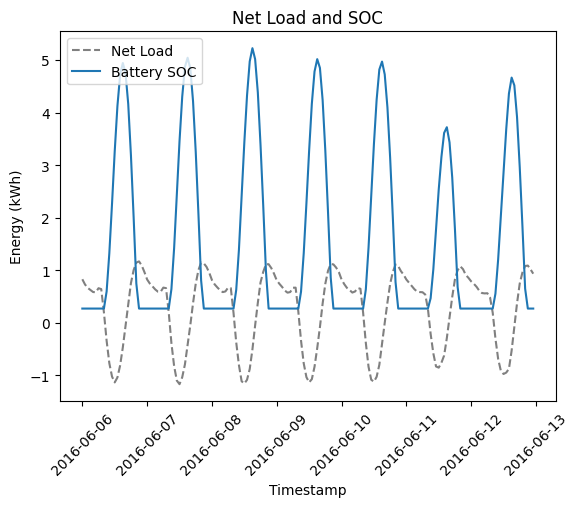

In [ ]:
price_optimizer.bilevel_optimize(method='BFGS', inner_method='l_bfgs_b_optimize')
price_optimizer.plot_results(week_avg.index, False)

### SLSQP as Inner Optimization

SLSQP is naturally more accurate. There are two worlds where this is desirable: large computing resources where the accuracy justifies the extended computation. Or, if the L-BFGS-B requires such high levels of function calls (Maxfun) to create a smooth optimization plane that SLSQP and L-BFGS-B are essentially the same runtime. 

In [26]:
price_optimizer.bilevel_optimize(method='BFGS')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {charge_optimizer.result.fun}')
price_optimizer.plot_results(week_avg.index, False)

Iteration of battery capacity: 2.0. Objective value: 26.10736619517631
Iteration of battery capacity: 4.0. Objective value: 21.772092015278318


KeyboardInterrupt: 

## Week Long; Local Optimization


Optimization terminated successfully    (Exit mode 0)
            Current function value: 18.282076518486388
            Iterations: 533
            Function evaluations: 92379
            Gradient evaluations: 533
Battery Size: 6.191349069681499 kWh
Objective Function Final Value: 18.282076518486388


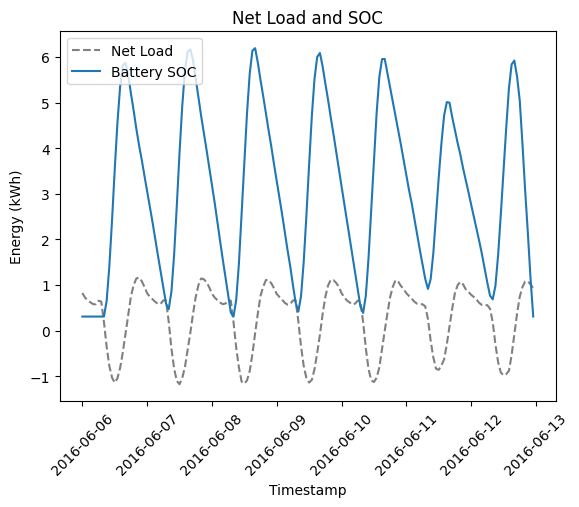

In [27]:
price_optimizer.local_optimize(method='SLSQP')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(week_avg.index, False)

# Year Long Optimization

In [17]:
year_avg = df.groupby([df['Timestamp'].dt.day_of_year, df['Timestamp'].dt.hour]).mean()
print(year_avg.shape)
year_avg['Timestamp'] = year_avg['Timestamp'].dt.round('h')
year_avg.set_index('Timestamp', inplace=True)
year_avg = year_avg / 1000  # Convert to kWh
# year_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Year Average Consumption', figsize=(12, 6))
# plt.show()

# Find datetime values that do not increment by one hour
duplicate_times = year_avg.index[year_avg.index.duplicated()]
print(duplicate_times)

# Print the incorrect datetimes
year_avg.tail()

(8784, 8)
DatetimeIndex([], dtype='datetime64[ns]', name='Timestamp', freq=None)


,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-12-31 19:00:00,0.614941,1.879544,0.0,0.586632,0.0,1.879544,1.879544
2016-12-31 20:00:00,0.614941,1.682954,0.0,0.586632,0.0,1.682954,1.682954
2016-12-31 21:00:00,0.614941,1.480107,0.0,0.586632,0.0,1.480107,1.480107
2016-12-31 22:00:00,0.614941,1.191320,0.0,0.586632,0.0,1.191320,1.191320
2016-12-31 23:00:00,0.614941,0.978168,0.0,0.586632,0.0,0.978168,0.978168


In [18]:
# Adjust the optimizers accordingly
charge_optimizer.set_new_input(year_avg['NetLoad'], 366, import_tariff, export_tariff, 1)
price_optimizer.set_new_input(year_avg['NetLoad'], 366, import_tariff, export_tariff, 1)
print(price_optimizer.pred_net_load.shape[0])

8784


In [19]:
price_optimizer.local_optimize()